# Tutorial for BBH injection and recovery

This tutorial will show how to inject a GW signal for a BBH event and how to proceed with the inference of the parameters.

## Injection

We can run the injection with a simple command, we only need a config file (params_BBH.ini) with the desired parameters and the approximant used.

```
 bajes_inject -o ./injection --wave ./params_BBH.ini --seglen 16 --srate 4096 --t-gps 126259462.0 --ifo H1 --asd design --ifo L1 
 --asd design --zero-noise --fd-inj
 ```

In [2]:
from bajes.pipe import execute_bash

inj_command = "bajes_inject --outdir ./injection --wave ./params_BBH.ini --seglen 16 --srate 4096 --t-gps 126259462.0 --ifo H1 --asd design --ifo L1 --asd design --zero-noise --fd-inj"
execute_bash(inj_command)

(20, 2048)

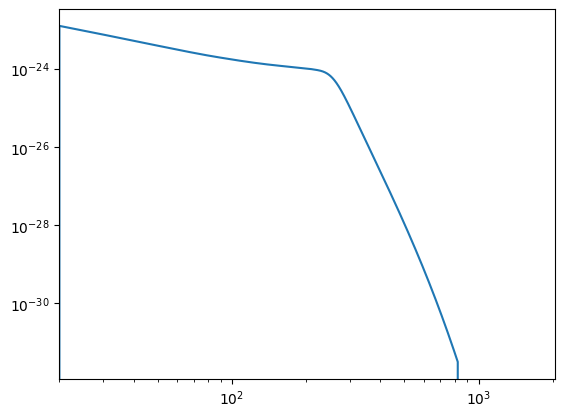

In [2]:
import numpy as np
import matplotlib.pyplot as plt

injection_file      = 'injection/H1_INJECTION.txt'
freq, r_inj, im_inj = np.genfromtxt(injection_file, unpack=True)

plt.loglog(freq, np.abs(r_inj - 1j * im_inj))
plt.xlim(20, 2048)

## Inference

The inference can be started with two commands.

```
bajes_setup -o ./run --tag gw --ifo H1 --asd design --strain ./injection/H1_INJECTION.txt --ifo L1 --asd design 
--strain ./injection/L1_INJECTION.txt --seglen 16 --srate 4096 --t-gps 126259462.0 --f-min 20 --f-max 2048 
--gw-approx LALSimFD-IMRPhenomXP --mc-min 23 --mc-max 37 --q-max 8 --spin-flag align-isotropic --spin-max 0.9 
--dist-min 100. --dist-max 5000. --marg-phi-ref --fd-inj
```

```
python -m bajes -o ./run -I ./run/inf.pkl --checkpoint 1000 --engine dynesty --nlive 1024 --seed 1234567 --verbose
```

In [25]:
setup_command = "bajes_setup -o ./run --tag gw --ifo H1 --asd design --strain ./injection/H1_INJECTION.txt --ifo L1 --asd design --strain ./injection/L1_INJECTION.txt --seglen 16 --srate 4096 --t-gps 126259462.0 --f-min 20 --f-max 2048 --gw-approx LALSimFD-IMRPhenomXP --mc-min 23 --mc-max 37 --q-max 8 --spin-flag align-isotropic --spin-max 0.9 --dist-min 100. --dist-max 5000. --marg-phi-ref --fd-inj"
execute_bash(setup_command)

inf_command = "python -m bajes -o ./run -I ./run/inf.pkl --checkpoint 1000 --engine dynesty --nlive 1024 --seed 1234567 --verbose"
execute_bash(inf_command)

## Postprocess

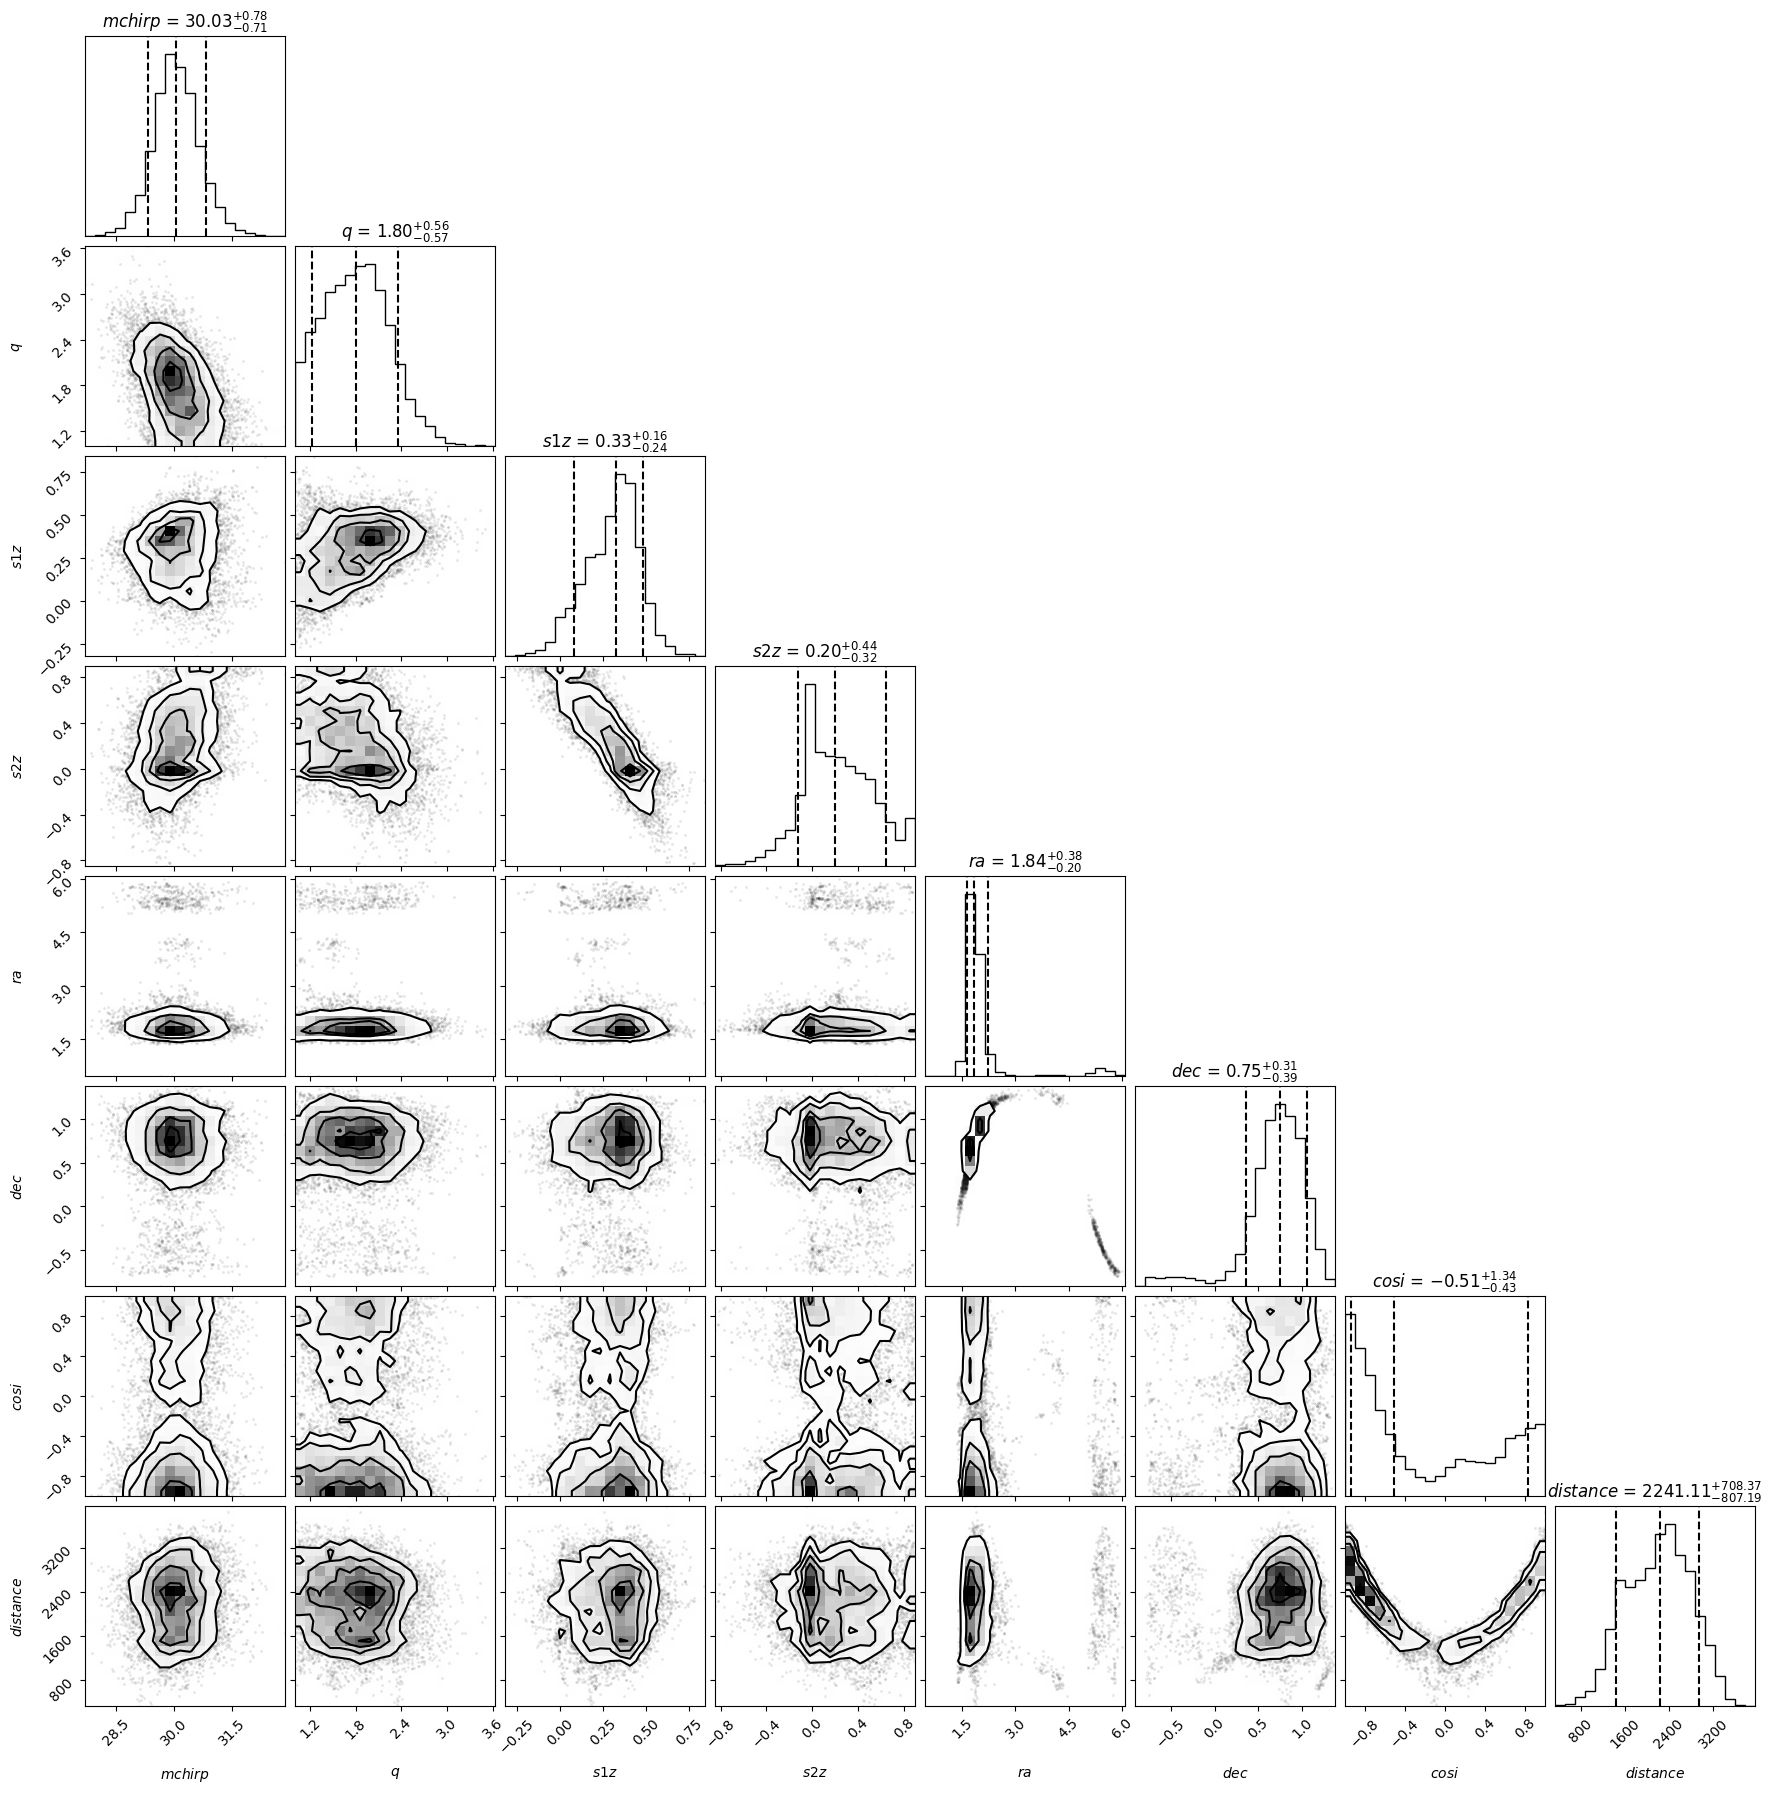

In [6]:
import numpy as np
import corner

posterior_file = './run/posterior.dat'
posterior      = np.genfromtxt(posterior_file, names=True)


figure = corner.corner(np.vstack([posterior['mchirp'], posterior['q'], posterior['s1z'],posterior['s2z'], posterior['ra'], posterior['dec'], posterior['cos_iota'], posterior['distance']]).T,
                labels=[r"$mchirp$", r"$q$", r"$s1z$", r"$s2z$", r"$ra$", r"$dec$", r"$cosi$", r"$distance$"], show_titles=True, title_kwargs={"fontsize": 12}, 
                quantiles=[0.1, 0.5, 0.9],
                )

There is also a command for the whole postprocess.

```
bajes_postproc -o ./run --verbose --spin-flag align-isotropic
```

In [ ]:
post_command = "bajes_postproc -o ./run --verbose --spin-flag align-isotropic"
execute_bash(post_command)

# Relative binning

The commands for using the relative binning in the inference are similar, we only need to have a fiducial section in the params_BBH.ini file. 

```
bajes_setup -o ./run --tag gw --ifo H1 --asd design --strain ./injection/H1_INJECTION.txt --ifo L1 --asd design 
--strain ./injection/L1_INJECTION.txt --seglen 16 --srate 4096 --t-gps 126259462.0 --f-min 20 --f-max 2048 
--gw-approx LALSimFD-IMRPhenomXP --mc-min 23 --mc-max 37 --q-max 8 --spin-flag align-isotropic --spin-max 0.9 -
-dist-min 100. --dist-max 5000. --marg-time-shift --marg-phi-ref --fd-inj --use-binning --fiducial ./params_BBH.ini --eps 0.1
```

```
python -m bajes -o ./run -I ./run/inf.pkl --checkpoint 1000 --engine dynesty --nlive 1024 --seed 1234567 --verbose
```

```
bajes_postproc -o ./run --verbose --spin-flag align-isotropic --use-binning
```